In [1]:
import os

import xarray as xr
import rioxarray as rxr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Point
from shapely import geometry

from datetime import datetime

[Webpage for MCD19A2 data](https://lpdaac.usgs.gov/products/mcd19a2v006/)

[User Guide for MCD19A2](https://lpdaac.usgs.gov/documents/110/MCD19_User_Guide_V6.pdf)

[User Guide that has conversion formulas for modis tiles to lat/lon](https://modis-land.gsfc.nasa.gov/pdf/MODIS_C6_BA_User_Guide_1.0.pdf)

[MODIS grid](https://modis-land.gsfc.nasa.gov/MODLAND_grid.html)

In [2]:
data_dir = '/Volumes/Shores/MODIS/2021'

In [3]:
# https://www.researchgate.net/post/How_can_I_plot_MODIS_HDF-EOS_grid_images_into_geographic_coordinates_lat-lon
# https://modis-land.gsfc.nasa.gov/pdf/MODIS_C6_BA_User_Guide_1.0.pdf, Appendix B

#
# Calculator
# https://landweb.modaps.eosdis.nasa.gov/cgi-bin/developer/tilemap.cgi
#

R = 6371007.181 # m, the radius of the idealized sphere representing the Earth;
T = 1111950 # m, the height and width of each MODIS tile in the projection plane;
xmin = -20015109.354 # m, the western limit of the projection plane;
ymax = 10007554.677 # m, the northern limit of the projection plane;
w = T / 1200 # m, the actual size of a “1km” MODIS sinusoidal grid cell.

def lon_lat_to_modis_tile(lon, lat):
    lon, lat = np.radians((lon, lat))
    
    x = R * lon * np.cos(lat)
    y = R * lat
    
    H = np.floor((x - xmin) / T)
    V = np.floor((ymax - y) / T)
    
    i = (((ymax - y) % T)) / w - 0.5
    j = (((x - xmin) % T)) / w - 0.5
    
    return (H, V, i, j)

def modis_tile_location_to_lat_lon(H, V, i, j):
    x = (j + 0.5) * w + H * T + xmin
    y = ymax - (i + 0.5) * w - V * T
    lat = y / R
    lon = x /(R * np.cos(lat))
    return np.degrees((lon, lat))

def modis_file_path_to_tilenumber(file):
    return file.split('.')[4]

def tile_string_to_H_V(tile_string):
    # example: h12v08 -> (12, 8)
    H = int(tile_string[1:3])
    V = int(tile_string[4:])
    return (H, V)

In [4]:
locations = pd.read_csv('data/locations.csv')
lons = locations['Longitude'].values
lats = locations['Latitude'].values

In [5]:
# for (idx, row) in locations.iterrows():
#     (H, V, i, j) = lon_lat_to_modis_tile(row.Longitude, row.Latitude)
#     actual = (row.Longitude, row.Latitude)
#     estimate = modis_tile_location_to_lat_lon(H, V, i, j)
#     print(actual, estimate, np.abs((actual - estimate) / actual) * 100)

In [11]:
buffer = 3

Learned to do this from [this website](https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/open-MODIS-hdf4-files-python/)

In [12]:
df_files = pd.read_csv('data/files_containing_points_of_interest.csv')

In [13]:
def check_if_file_has_nonull_data(file, tiles, buffer=0):
    lats, lons, times, aod = [], [], [], []
    
    tile = modis_file_path_to_tilenumber(file)
    H, V = tile_string_to_H_V(tile)
    modis = rxr.open_rasterio(file,masked=True)[0]
    scale_factor = modis['Optical_Depth_055'].attrs['scale_factor']
    bands = modis.attrs['Orbit_amount']
    
    for offset in tiles[tile]:
        (x, y) = np.array(offset).astype(int)
        i, j = offset
        value = modis.isel(x=slice(x-buffer, x+buffer+1), y=slice(y-buffer, y+buffer+1))['Optical_Depth_055']
        if not np.all(value.isnull()):
            return True
    return False

In [15]:
files_with_non_null_values = []
files_with_errors = []

for row in df_files.iterrows():
    file = row[1].files
    try:
        if check_if_file_has_nonull_data(file, tiles, buffer=buffer):
            files_with_non_null_values.append(file)
    except Exception as E:
        print(E)
        files_with_errors.append(file)

'/Volumes/Shores/MODIS/2021/2021.03.07/MCD19A2.A2021066.h12v05.006.2021068132112.hdf' not recognized as a supported file format.
'/Volumes/Shores/MODIS/2021/2021.03.29/MCD19A2.A2021088.h10v05.006.2021090044610.hdf' not recognized as a supported file format.
'/Volumes/Shores/MODIS/2021/2021.03.29/MCD19A2.A2021088.h11v04.006.2021090045940.hdf' not recognized as a supported file format.
'/Volumes/Shores/MODIS/2021/2021.03.29/MCD19A2.A2021088.h11v05.006.2021090044958.hdf' not recognized as a supported file format.


In [18]:
pd.DataFrame({'Files With Errors': files_with_errors}).to_csv('data/files_with_errors.csv', index=False)

In [19]:
df_any_non_nulls = pd.DataFrame({'files': np.unique(files_with_non_null_values)})
df_any_non_nulls

,files
0,/Volumes/Shores/MODIS/2021/2021.01.01/MCD19A2....
1,/Volumes/Shores/MODIS/2021/2021.01.01/MCD19A2....
2,/Volumes/Shores/MODIS/2021/2021.01.01/MCD19A2....
3,/Volumes/Shores/MODIS/2021/2021.01.01/MCD19A2....
4,/Volumes/Shores/MODIS/2021/2021.01.01/MCD19A2....
...,...
3425,/Volumes/Shores/MODIS/2021/2021.12.31/MCD19A2....
3426,/Volumes/Shores/MODIS/2021/2021.12.31/MCD19A2....
3427,/Volumes/Shores/MODIS/2021/2021.12.31/MCD19A2....
3428,/Volumes/Shores/MODIS/2021/2021.12.31/MCD19A2....


In [20]:
df_any_non_nulls.to_csv('data/files_with_any_nonnull_data.csv', index=False)

## Creating tile averages from files that have data

In [21]:
df_any_non_nulls = pd.read_csv('data/files_with_any_nonnull_data.csv')

In [22]:
def get_average_AOD_values(file, tiles, buffer=0):
    lats, lons, dates, aod = [], [], [], []
    
    tile = modis_file_path_to_tilenumber(file)
    H, V = tile_string_to_H_V(tile)
    modis = rxr.open_rasterio(file,masked=True)[0]
    scale_factor = modis['Optical_Depth_055'].attrs['scale_factor']
    bands = modis.attrs['Orbit_amount']
    times = [datetime.strptime(i[:-1], '%Y%j%H%M') for i in modis.attrs['Orbit_time_stamp'].split(' ') if len(i) > 0]
    
    for offset in tiles[tile]:
        (x, y) = np.array(offset).astype(int)
        i, j = offset
        for band, time in zip(range(bands), times):            
            value = modis.isel(x=slice(x-buffer, x+buffer+1), y=slice(y-buffer, y+buffer+1), band=band)['Optical_Depth_055']
            if not np.all(value.isnull()):
                lon, lat = modis_tile_location_to_lat_lon(H, V, i, j)
                lons.append(lon)
                lats.append(lat)
                aod.append(value.mean().values.item())
                dates.append(time)
    return pd.DataFrame({
        'Dates': dates,
        'Longitude': lons,
        'Latitude': lats,
        'AOD': aod,
    })

In [23]:
averaged_dfs = []

for row in df_any_non_nulls.iterrows():
    file = row[1].files
    averaged_dfs.append(get_average_AOD_values(file, tiles, buffer=buffer))

In [24]:
averaged_df = pd.concat(averaged_dfs)

In [25]:
averaged_df['AOD'] = averaged_df['AOD'] * 0.001

In [26]:
averaged_df.to_csv('data/7km_averaged_aod.csv', index=False)

# Plotting things

In [12]:
file = '/Volumes/Shores/MODIS/2017/2017.01.01/MCD19A2.A2017001.h08v05.006.2018114112131.hdf'
modis = rxr.open_rasterio(file,masked=True)[0]
tile = modis_file_path_to_tilenumber(file)
modis

<xarray.Dataset>
Dimensions:            (y: 1200, x: 1200, band: 5)
Coordinates:
  * y                  (y) float64 4.447e+06 4.446e+06 ... 3.337e+06 3.336e+06
  * x                  (x) float64 -1.112e+07 -1.112e+07 ... -1.001e+07
  * band               (band) int64 1 2 3 4 5
    spatial_ref        int64 0
Data variables:
    Optical_Depth_047  (band, y, x) float32 ...
    Optical_Depth_055  (band, y, x) float32 ...
    AOD_Uncertainty    (band, y, x) float32 ...
    FineModeFraction   (band, y, x) float32 ...
    Column_WV          (band, y, x) float32 ...
    AOD_QA             (band, y, x) float32 ...
    AOD_MODEL          (band, y, x) float32 ...
    Injection_Height   (band, y, x) float32 ...
Attributes: (12/85)
    ADDITIONALLAYERS:                   5
    ALGORITHMPACKAGEACCEPTANCEDATE:     TBD
    ALGORITHMPACKAGEMATURITYCODE:       Preliminary
    ALGORITHMPACKAGENAME:               MOD_PR19
    ALGORITHMPACKAGEVERSION:            2.0
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ...                                 ...
    TileID:                             51008005
    TOTALADDITIONALOBSERVATIONS:        596175
    TOTALOBSERVATIONS:                  7963072
    VERSIONID:                          6
    VERTICALTILENUMBER:                 5
    WESTBOUNDINGCOORDINATE:             -130.540728914638

In [15]:
[datetime.strptime(i[:-1], '%Y%j%H%M') for i in modis.attrs['Orbit_time_stamp'].split(' ') if len(i) > 0]

[datetime.datetime(2017, 1, 1, 17, 0),
 datetime.datetime(2017, 1, 1, 18, 40),
 datetime.datetime(2017, 1, 1, 20, 15),
 datetime.datetime(2017, 1, 1, 20, 15),
 datetime.datetime(2017, 1, 1, 21, 55)]

In [106]:
modis['Optical_Depth_055'].attrs['scale_factor']

0.001

In [122]:
modis['Optical_Depth_055'].isel(x=x, y=y, band=1)

<xarray.DataArray 'Optical_Depth_055' ()>
array(130., dtype=float32)
Coordinates:
    y            float64 3.985e+06
    x            float64 -1.077e+07
    band         int64 2
    spatial_ref  int64 0
Attributes:
    scale_factor:  0.001
    add_offset:    0.0
    long_name:     AOD at 0.55 micron

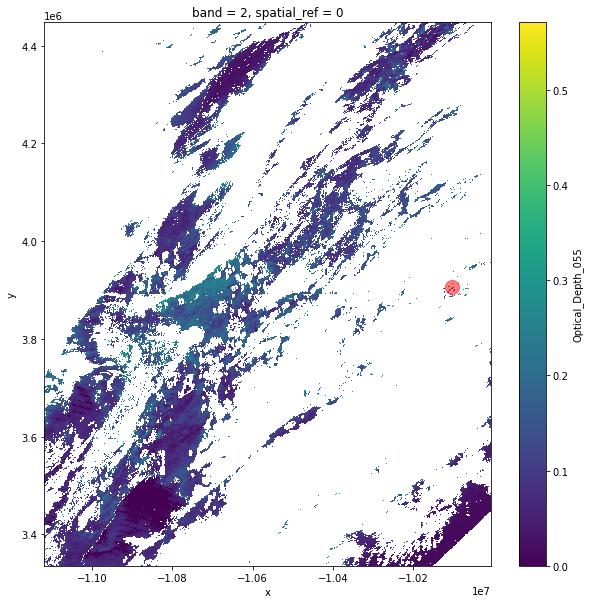

In [99]:
fig, ax = plt.subplots(figsize=(10, 10))

aod_550 = modis['Optical_Depth_055'] * 0.001
time = datetime.strptime(modis.attrs['Orbit_time_stamp'].split(' ') [2][:-1], '%Y%j%H%M') 

ax.set_title(time.strftime("%b %-d, %Y %H:%M"))
aod_550.sel(band=2).plot(ax=ax)

ax.scatter(modis.x[x], modis.y[y], s=200, c='red', alpha=0.5)

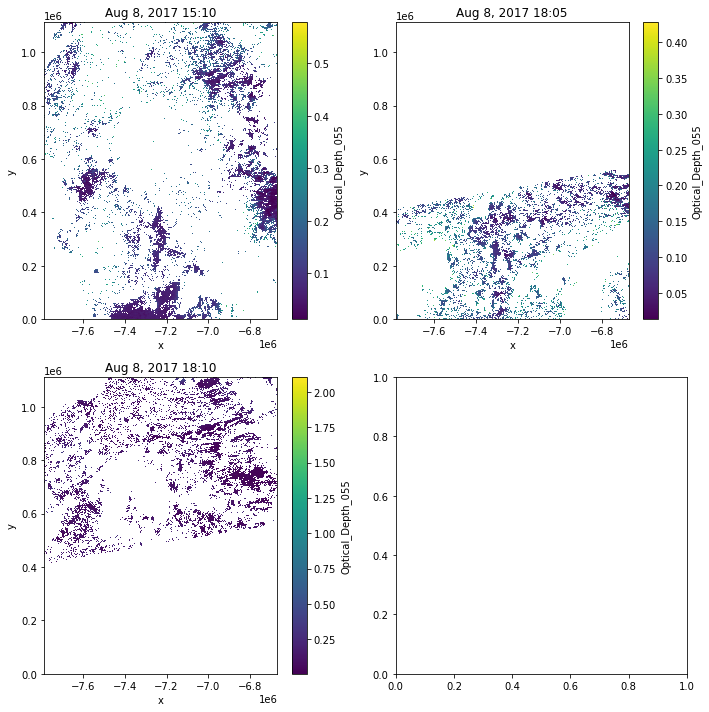

In [15]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))

aod_550 = modis['Optical_Depth_055'] * 0.001
times = [datetime.strptime(i[:-1], '%Y%j%H%M') 
         for i in modis.attrs['Orbit_time_stamp'].split(' ') 
         if len(i) > 0]

for band, ax in zip([1,2,3], axes.ravel()):
    aod_550.sel(band=band).plot(ax=ax)
    ax.set_title(times[band-1].strftime("%b %-d, %Y %H:%M"))
    
fig.tight_layout()